In [266]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from IPython.display import display
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import us
import seaborn as sns
from linearmodels.iv import IV2SLS

In [267]:
gdpcomp_file_path = "/Users/markoshea/Desktop/Working Directories/Datasets/rep_files/DATA/gdpandcomp.dta"
gdpcomp_df = pd.read_stata(gdpcomp_file_path)

indshares_file_path = "/Users/markoshea/Desktop/Working Directories/Datasets/rep_files/DATA/indshares.dta"
indshares_df = pd.read_stata(indshares_file_path)

otheroutcomes_bpl_file_path = "/Users/markoshea/Desktop/Working Directories/Datasets/rep_files/DATA/otheroutcomes_bpl.dta"
otheroutcomes_bpl_df = pd.read_stata(otheroutcomes_bpl_file_path)

spred10_bpl_file_path = "/Users/markoshea/Desktop/Working Directories/Datasets/rep_files/DATA/spred10_bpl.dta"
spred10_bpl_df = pd.read_stata(spred10_bpl_file_path)

spred0_file_path = "/Users/markoshea/Desktop/Working Directories/Datasets/rep_files/DATA/spred0.dta"
spred0_df = pd.read_stata(spred0_file_path)

spred10_file_path = "/Users/markoshea/Desktop/Working Directories/Datasets/rep_files/DATA/spred10.dta"
spred10_df = pd.read_stata(spred10_file_path)

spred20_file_path = "/Users/markoshea/Desktop/Working Directories/Datasets/rep_files/DATA/spred20.dta"
spred20_df = pd.read_stata(spred20_file_path)

spred30_file_path = "/Users/markoshea/Desktop/Working Directories/Datasets/rep_files/DATA/spred30.dta"
spred30_df = pd.read_stata(spred30_file_path)

spred40_file_path = "/Users/markoshea/Desktop/Working Directories/Datasets/rep_files/DATA/spred40.dta"
spred40_df = pd.read_stata(spred40_file_path)

ACS_100sampled_file_path = "/Users/markoshea/Desktop/Working Directories/Datasets/rep_files/DATA/ACS_100sampled.csv"
ACS_100sampled_df = pd.read_csv(ACS_100sampled_file_path, low_memory=False)

In [268]:
#to map from states to fips code
state_name_to_fips = {state.name: state.fips for state in us.states.STATES + [us.states.DC]}
print(state_name_to_fips) 

{'Alabama': '01', 'Alaska': '02', 'Arizona': '04', 'Arkansas': '05', 'California': '06', 'Colorado': '08', 'Connecticut': '09', 'Delaware': '10', 'Florida': '12', 'Georgia': '13', 'Hawaii': '15', 'Idaho': '16', 'Illinois': '17', 'Indiana': '18', 'Iowa': '19', 'Kansas': '20', 'Kentucky': '21', 'Louisiana': '22', 'Maine': '23', 'Maryland': '24', 'Massachusetts': '25', 'Michigan': '26', 'Minnesota': '27', 'Mississippi': '28', 'Missouri': '29', 'Montana': '30', 'Nebraska': '31', 'Nevada': '32', 'New Hampshire': '33', 'New Jersey': '34', 'New Mexico': '35', 'New York': '36', 'North Carolina': '37', 'North Dakota': '38', 'Ohio': '39', 'Oklahoma': '40', 'Oregon': '41', 'Pennsylvania': '42', 'Rhode Island': '44', 'South Carolina': '45', 'South Dakota': '46', 'Tennessee': '47', 'Texas': '48', 'Utah': '49', 'Vermont': '50', 'Virginia': '51', 'Washington': '53', 'West Virginia': '54', 'Wisconsin': '55', 'Wyoming': '56', 'District of Columbia': '11'}


In [269]:
#light data cleaning

#verify 'year' is int and convert 'stfips'
for df_name, df in zip(["spred10", "spred20", "spred30", "spred40", "spred0", "gdpcomp", "otheroutcomes_bpl"], 
                        [spred10_df, spred20_df, spred30_df, spred40_df, spred0_df, gdpcomp_df, otheroutcomes_bpl_df]):
    df['year'] = df['year'].astype(int)

    #mapping only if stfips is stored as strings (state names)
    if df['stfips'].dtype == 'object' or df['stfips'].dtype.name == 'category':
        df['stfips'] = df['stfips'].map(state_name_to_fips)

    #drop NaN values before converting to integers
    df.dropna(subset=['stfips'], inplace=True)

    df['stfips'] = df['stfips'].astype(int)

    print(f"Cleaned {df_name}: Unique stfips values now:", df['stfips'].unique()[:10])

Cleaned spred10: Unique stfips values now: [ 1  2  4  5  6  8  9 10 11 12]
Cleaned spred20: Unique stfips values now: [ 1  2  4  5  6  8  9 10 11 12]
Cleaned spred30: Unique stfips values now: [ 1  2  4  5  6  8  9 10 11 12]
Cleaned spred40: Unique stfips values now: [ 1  2  4  5  6  8  9 10 11 12]
Cleaned spred0: Unique stfips values now: [ 1  2  4  5  6  8  9 10 11 12]
Cleaned gdpcomp: Unique stfips values now: [ 1  2  4  5  6  8  9 10 11 12]
Cleaned otheroutcomes_bpl: Unique stfips values now: [ 1  2  4  5  6  8  9 10 11 12]


In [243]:
#Compensation_st = total state labor compensation in year t using BEA's measure
#of total labor compensation (labor earnings plus non-cash compensation)
#GDP_st / Hours_st = GDP_st / Comp_st * Comp_st / Hours_st

#GDP_st / N_st = GDP_st / Hours_st * Hours_st / L_st * L_st / N_st
#L is level of employment for workers aged 20+

In [244]:
#equation 1 

#ln(GDP_(st + 10) / N_(st + 10)) - ln(GDP_st / N_st) 
# = 
# beta * [ln(A_(st + 10) / N_(st + 10)) - ln(A_st / N_st)] + X'_st * delta_t + gamma_t 
#+ (epsilon_(st+10) - epsilon_st)

#A_st is the number of individuals aged 60 and older in state s and year t
#N_st is the state population 20 and older in year t
#X_st is a set of time-varying control variables whose influence
#gamma_t is time fixed effects
#epsilon_st is state output shocks

In [245]:
#equation 1, revised based on available data I see

#ln(GDP_(st + 10) / N_(st + 10)) - ln(GDP_st / N_st) 
# = 
# beta * [ln(A_(st + 10) / N_(st + 10)) - ln(A_st / N_st)] + (epsilon_(st+10) - epsilon_st)

#A_st is the number of individuals aged 60 and older in state s and year t
#N_st is the state population 20 and older in year t
#epsilon_st is state output shocks

In [270]:
# Define decade intervals (t to t+10)
years = [1989, 1999]

# Filter the datasets for these years
spred10_filtered = spred10_df[spred10_df['year'].isin(years)].copy()
gdp_filtered = gdpcomp_df[gdpcomp_df['year'].isin(years)].copy()

# Compute the number of individuals aged 60+
spred10_filtered['A_st'] = spred10_filtered[['pred10num6', 'pred10num7', 'pred10num8', 'pred10num9']].sum(axis=1)

# Compute per capita GDP
gdp_filtered['per_capita_gdp'] = gdp_filtered['gdp'] / gdp_filtered['comp']  # Assuming 'comp' represents N_st

# Merge datasets by 'stfips' and 'year'
merged_df = pd.merge(spred10_filtered[['stfips', 'year', 'A_st']],
                     gdp_filtered[['stfips', 'year', 'per_capita_gdp', 'comp']],
                     on=['stfips', 'year'])

# Reshape the data to calculate differences for (t+10) - t
df_t = merged_df[merged_df['year'] == 1989].set_index('stfips')
df_t10 = merged_df[merged_df['year'] == 1999].set_index('stfips')

# Ensure only states present in both years are kept
valid_states = df_t.index.intersection(df_t10.index)
df_t = df_t.loc[valid_states]
df_t10 = df_t10.loc[valid_states]

# Compute growth in per capita GDP
gdp_growth = np.log(df_t10['per_capita_gdp']) - np.log(df_t['per_capita_gdp'])

# Compute growth in share of 60+ population
pop_share_t = df_t['A_st'] / df_t['comp']
pop_share_t10 = df_t10['A_st'] / df_t10['comp']
pop60_growth = np.log(pop_share_t10) - np.log(pop_share_t)

# Run the regression
X = sm.add_constant(pop60_growth)  # Add intercept
y = gdp_growth
model = sm.OLS(y, X).fit()

# Print regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         per_capita_gdp   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     4.180
Date:                Sat, 15 Mar 2025   Prob (F-statistic):             0.0463
Time:                        07:14:39   Log-Likelihood:                 66.402
No. Observations:                  51   AIC:                            -128.8
Df Residuals:                      49   BIC:                            -124.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0628      0.027     -2.343      0.0

Valid states found after fixing stfips: 51
Number of states included: 51
   stfips  real_growth  gdp_growth
0       1     9.852573   -1.102734
1       2    48.813570  -25.977325
2       4    38.346252    4.326318
3       5     7.494218   -2.313830
4       6    11.988115    3.165751


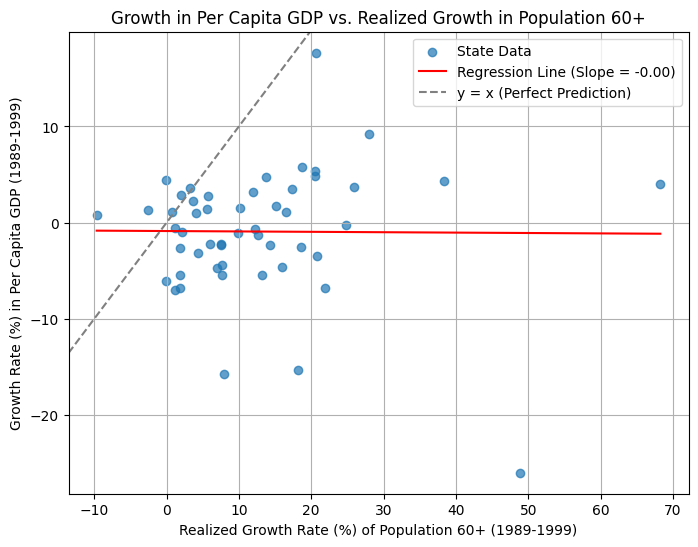

In [271]:
#panel A: aging and per capita GDP growth
# Ensure 'year' is stored as an integer
spred0_df['year'] = spred0_df['year'].astype(int)
gdpcomp_df['year'] = gdpcomp_df['year'].astype(int)

# Convert 'stfips' to integers for matching
spred0_df['stfips'] = spred0_df['stfips'].astype(int)
gdpcomp_df['stfips'] = gdpcomp_df['stfips'].astype(int)

# Use only valid years for analysis (1989-1999)
valid_years = [1989, 1999]
spred0_filtered = spred0_df[spred0_df['year'].isin(valid_years)].copy()
gdp_filtered = gdpcomp_df[gdpcomp_df['year'].isin(valid_years)].copy()

# Compute the realized population aged 60+
spred0_filtered['pop_60_plus'] = spred0_filtered[['pred0num6', 'pred0num7', 'pred0num8', 'pred0num9']].sum(axis=1)

# Compute per capita GDP
gdp_filtered['per_capita_gdp'] = gdp_filtered['gdp'] / gdp_filtered['comp']

# Identify valid states (those that appear in both datasets and have both years)
valid_states = set(spred0_filtered['stfips'].unique()) & set(gdp_filtered['stfips'].unique())

valid_states = {
    state for state in valid_states
    if set(spred0_filtered[spred0_filtered['stfips'] == state]['year']) == {1989, 1999}
    and set(gdp_filtered[gdp_filtered['stfips'] == state]['year']) == {1989, 1999}
}

print(f"Valid states found after fixing stfips: {len(valid_states)}")

growth_rates = []
for state in valid_states:
    real_state = spred0_filtered[spred0_filtered['stfips'] == state].sort_values('year')
    gdp_state = gdp_filtered[gdp_filtered['stfips'] == state].sort_values('year')

    if len(real_state) == 2 and len(gdp_state) == 2:
        # Compute initial and final values
        initial_real = real_state['pop_60_plus'].iloc[0]
        final_real = real_state['pop_60_plus'].iloc[-1]
        initial_gdp = gdp_state['per_capita_gdp'].iloc[0]
        final_gdp = gdp_state['per_capita_gdp'].iloc[-1]

        # Compute percentage growth rates
        real_growth = ((final_real - initial_real) / initial_real) * 100 if initial_real > 0 else None
        gdp_growth = ((final_gdp - initial_gdp) / initial_gdp) * 100 if initial_gdp > 0 else None

        if real_growth is not None and gdp_growth is not None:
            growth_rates.append({'stfips': state, 'real_growth': real_growth, 'gdp_growth': gdp_growth})

# Convert to DataFrame
growth_df = pd.DataFrame(growth_rates)

# Debugging statement to check state count
print(f"Number of states included: {len(growth_df)}")
print(growth_df.head())

# Perform Linear Regression
if not growth_df.empty:
    X = growth_df[['real_growth']].values  # Predictor (reshaped for sklearn)
    y = growth_df['gdp_growth'].values  # Response

    reg = LinearRegression().fit(X, y)  # Fit regression model
    slope = reg.coef_[0]  # Extract slope

    # Generate regression line for plotting
    x_range = np.linspace(min(growth_df['real_growth']), max(growth_df['real_growth']), 100).reshape(-1, 1)
    y_pred = reg.predict(x_range)

    # Scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(growth_df['real_growth'], growth_df['gdp_growth'], alpha=0.7, label="State Data")
    plt.plot(x_range, y_pred, color='red', linestyle='-', label=f"Regression Line (Slope = {slope:.2f})")
    plt.axline((0, 0), slope=1, linestyle="--", color="gray", label="y = x (Perfect Prediction)")

    # Formatting
    plt.xlabel("Realized Growth Rate (%) of Population 60+ (1989-1999)")
    plt.ylabel("Growth Rate (%) in Per Capita GDP (1989-1999)")
    plt.title("Growth in Per Capita GDP vs. Realized Growth in Population 60+")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Warning: No valid states available. Check data consistency.")


Number of states included: 51
   stfips  pred_growth  real_growth
0       1    24.121779     9.852573
1       2    68.096298    48.813570
2       4    56.598330    38.346252
3       5    24.506135     7.494218
4       6    26.792729    11.988115


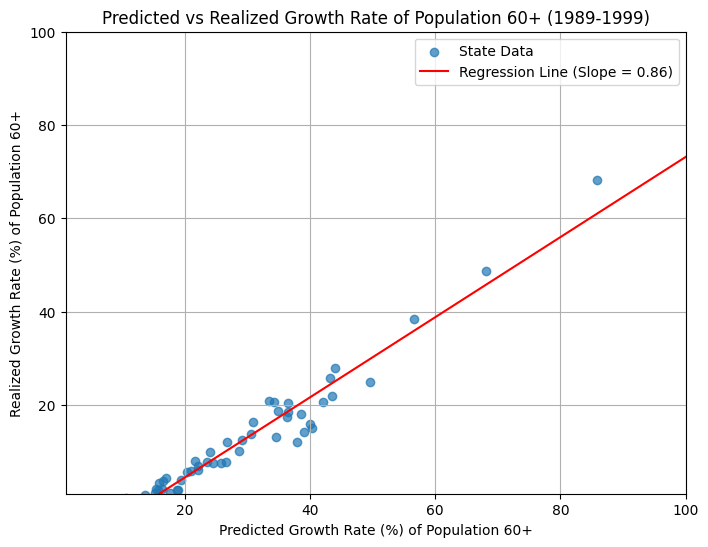

In [272]:
#panel B: predicted aging and observed aging
#y: Growth rate in % of pop. above 60+
#x: Predicted growth rate in % of pop. 60+
#slope = 0.827

# Use only valid years based on lag structure
valid_years = [1989, 1999]  # Exclude 2009 for spred10

spred10_filtered = spred10_df[spred10_df['year'].isin(valid_years)].copy()
spred0_filtered = spred0_df[spred0_df['year'].isin(valid_years)].copy()

# Compute the population aged 60+ for predictions and realizations
spred10_filtered['pop_60_plus'] = spred10_filtered[['pred10num6', 'pred10num7', 'pred10num8', 'pred10num9']].sum(axis=1)
spred0_filtered['pop_60_plus'] = spred0_filtered[['pred0num6', 'pred0num7', 'pred0num8', 'pred0num9']].sum(axis=1)

# Identify valid states (only those with 2 years)
valid_states = set(spred10_filtered['stfips'].unique()) & set(spred0_filtered['stfips'].unique())

growth_rates = []
for state in valid_states:
    pred_state = spred10_filtered[spred10_filtered['stfips'] == state].sort_values('year')
    real_state = spred0_filtered[spred0_filtered['stfips'] == state].sort_values('year')
    
    if len(pred_state) == 2 and len(real_state) == 2:  # Only compare two valid years
        initial_pred = pred_state['pop_60_plus'].iloc[0]
        final_pred = pred_state['pop_60_plus'].iloc[-1]
        initial_real = real_state['pop_60_plus'].iloc[0]
        final_real = real_state['pop_60_plus'].iloc[-1]
        
        # Compute percentage growth
        pred_growth = ((final_pred - initial_pred) / initial_pred) * 100 if initial_pred > 0 else None
        real_growth = ((final_real - initial_real) / initial_real) * 100 if initial_real > 0 else None

        if pred_growth is not None and real_growth is not None:
            growth_rates.append({'stfips': state, 'pred_growth': pred_growth, 'real_growth': real_growth})

growth_df = pd.DataFrame(growth_rates)

print(f"Number of states included: {len(growth_df)}")
print(growth_df.head())

if not growth_df.empty:
    X = growth_df[['pred_growth']].values 
    y = growth_df['real_growth'].values  

    reg = LinearRegression().fit(X, y) 
    slope = reg.coef_[0] 

    x_range = np.linspace(1, 100, 100).reshape(-1, 1)
    y_pred = reg.predict(x_range)

    plt.figure(figsize=(8, 6))
    plt.scatter(growth_df['pred_growth'], growth_df['real_growth'], alpha=0.7, label="State Data")
    plt.plot(x_range, y_pred, color='red', linestyle='-', label=f"Regression Line (Slope = {slope:.2f})")

    plt.xlim(1, 100)  # Restrict x-axis from 1% to 100%
    plt.ylim(1, 100)  # Restrict y-axis from 1% to 100%
    plt.xlabel("Predicted Growth Rate (%) of Population 60+")
    plt.ylabel("Realized Growth Rate (%) of Population 60+")
    plt.title("Predicted vs Realized Growth Rate of Population 60+ (1989-1999)")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Warning: No valid states available. Check data consistency.")

Table 1 Notes: Number of observations = 153 in all regressions. Standard errors in parentheses adjusted for clustering at state level. Each observation is weighted by period t population. Δy ≡ y s,t+10 − y st . Other variables included: year dummies; the log of the fraction of workers in the applicable initial period (i.e., period t ) working in each of the following industries: agriculture, mining, construction, manufacturing, transportation, communications/utilities,
wholesale trade, retail trade, finance/insurance/real estate, business and repair services, personal services, recreation services, professional services, and public administration. The industry composition variables are interacted with the time dummies to allow the effects of initial industry composition to vary by year.

In [273]:
# Define instrument lags and corresponding datasets
lagged_instruments = {
    10: spred10_df,
    20: spred20_df,
    30: spred30_df,
    40: spred40_df
}

# Define full set of years
years = [1969, 1979, 1989, 1999, 2009]

# Drop years for each lagged instrument (as per dataset construction)
drop_years = {
    10: [2009],
    20: [1999, 2009],
    30: [1989, 1999, 2009],
    40: [1979, 1989, 1999, 2009]
}

# Prepare results storage
results_table = pd.DataFrame(index=['Reduced Form', 'First Stage', 'IV Estimate'], columns=[10, 20, 30, 40])

# Loop through each lagged instrument
for lag, spred_df in lagged_instruments.items():
    print(f"Running regressions for {lag}-year lagged instrument...")

    # Define valid years based on known zero patterns
    valid_years = [year for year in years if year not in drop_years[lag]]

    # Filter datasets for relevant years
    spred_filtered = spred_df[spred_df['year'].isin(valid_years)].copy()
    spred0_filtered = spred0_df[spred0_df['year'].isin(valid_years)].copy()
    gdp_filtered = gdpcomp_df[gdpcomp_df['year'].isin(valid_years)].copy()

    # Compute the predicted number of individuals aged 60+ (A^)
    pred_columns = [f'pred{lag}num6', f'pred{lag}num7', f'pred{lag}num8', f'pred{lag}num9']
    spred_filtered['A_hat'] = spred_filtered[pred_columns].sum(axis=1)

    # Compute the realized number of individuals aged 60+ (A)
    real_columns = ['pred0num6', 'pred0num7', 'pred0num8', 'pred0num9']
    spred0_filtered['A_real'] = spred0_filtered[real_columns].sum(axis=1)

    # Compute per capita GDP
    gdp_filtered['per_capita_gdp'] = gdp_filtered['gdp'] / gdp_filtered['comp']

    # Merge datasets by 'stfips' and 'year'
    merged_df = pd.merge(spred_filtered[['stfips', 'year', 'A_hat']],
                         gdp_filtered[['stfips', 'year', 'per_capita_gdp', 'comp']],
                         on=['stfips', 'year'])
    
    merged_df = pd.merge(merged_df,
                         spred0_filtered[['stfips', 'year', 'A_real']],
                         on=['stfips', 'year'])

    # Compute log differences for all (t, t+10) pairs
    growth_data = []
    for t in valid_years:
        t10 = t + 10
        if t10 not in valid_years:
            continue  # Skip if t+10 is outside valid years

        df_t = merged_df[merged_df['year'] == t].set_index('stfips')
        df_t10 = merged_df[merged_df['year'] == t10].set_index('stfips')

        # Ensure only states present in both periods are kept
        valid_states = df_t.index.intersection(df_t10.index)
        df_t = df_t.loc[valid_states]
        df_t10 = df_t10.loc[valid_states]

        # Compute changes in log values
        gdp_growth = np.log(df_t10['per_capita_gdp']) - np.log(df_t['per_capita_gdp'])
        pred_pop_share_t = df_t['A_hat'] / df_t['comp']
        pred_pop_share_t10 = df_t10['A_hat'] / df_t10['comp']
        pred_pop_growth = np.log(pred_pop_share_t10) - np.log(pred_pop_share_t)
        real_pop_share_t = df_t['A_real'] / df_t['comp']
        real_pop_share_t10 = df_t10['A_real'] / df_t10['comp']
        real_pop_growth = np.log(real_pop_share_t10) - np.log(real_pop_share_t)

        # Store values for regression
        for state in valid_states:
            growth_data.append({
                'stfips': state,
                'gdp_growth': gdp_growth[state],
                'pred_pop_growth': pred_pop_growth[state],
                'real_pop_growth': real_pop_growth[state]
            })

    # Convert to DataFrame
    growth_df = pd.DataFrame(growth_data).dropna()

    # Ensure we have data for regression
    if growth_df.empty:
        print(f"Skipping {lag}-year instrument due to insufficient data.")
        continue

    # Panel A: Reduced Form Estimate
    X_reduced = sm.add_constant(growth_df['gdp_growth'])
    y_reduced = growth_df['pred_pop_growth']
    reduced_form = sm.OLS(y_reduced, X_reduced).fit()
    results_table.loc['Reduced Form', lag] = reduced_form.params[1]

    # Panel B: First Stage Estimate
    X_first_stage = sm.add_constant(growth_df['real_pop_growth'])
    y_first_stage = growth_df['pred_pop_growth']
    first_stage = sm.OLS(y_first_stage, X_first_stage).fit()
    results_table.loc['First Stage', lag] = first_stage.params[1]

    # Panel C: IV Estimate
    iv_model = IV2SLS(
        dependent=growth_df['real_pop_growth'],  
        exog=sm.add_constant(np.ones(len(growth_df))),  
        endog=growth_df['gdp_growth'],  
        instruments=growth_df['pred_pop_growth']  
    ).fit()
    results_table.loc['IV Estimate', lag] = iv_model.params[1]

display(results_table)

# Print results for verification
print("IV Regression Results:")
print(results_table)

Running regressions for 10-year lagged instrument...
Running regressions for 20-year lagged instrument...
Running regressions for 30-year lagged instrument...
Running regressions for 40-year lagged instrument...
Skipping 40-year instrument due to insufficient data.


/var/folders/k7/qpdvs2d90yx6n0tx8c1_tj8c0000gn/T/ipykernel_34533/3026372446.py:100: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results_table.loc['Reduced Form', lag] = reduced_form.params[1]
/var/folders/k7/qpdvs2d90yx6n0tx8c1_tj8c0000gn/T/ipykernel_34533/3026372446.py:106: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results_table.loc['First Stage', lag] = first_stage.params[1]
/var/folders/k7/qpdvs2d90yx6n0tx8c1_tj8c0000gn/T/ipykernel_34533/3026372446.py:115: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent

,10,20,30,40
Reduced Form,-0.397104,1.3456,-0.19567,NaN
First Stage,1.178224,1.144549,0.542883,NaN
IV Estimate,-35.442018,11.772689,-17.565589,NaN


IV Regression Results:
                     10         20         30   40
Reduced Form  -0.397104     1.3456   -0.19567  NaN
First Stage    1.178224   1.144549   0.542883  NaN
IV Estimate  -35.442018  11.772689 -17.565589  NaN


In [274]:
#table 2 - decomposing main effect
#instrument length: 10 year lag
#four cols
#∆ln(A/N) = ∆ln(GDP/N), ∆ln(GDP/hours), ∆ln(H/L), ∆ln(L/N)
# Define valid years (drop 2009 for 10-year lag)
valid_years = [1999]

# Filter datasets
spred_filtered = spred10_df[spred10_df['year'].isin(valid_years)].copy()
spred0_filtered = spred0_df[spred0_df['year'].isin(valid_years)].copy()
gdp_filtered = gdpcomp_df[gdpcomp_df['year'].isin(valid_years)].copy()
earnings_filtered = otheroutcomes_bpl_df[otheroutcomes_bpl_df['year'].isin(valid_years)].copy()

# Compute predicted number of 60+ individuals (A^)
spred_filtered['A_hat'] = spred_filtered[['pred10num6', 'pred10num7', 'pred10num8', 'pred10num9']].sum(axis=1)

# Compute realized number of 60+ individuals (A)
spred0_filtered['A_real'] = spred0_filtered[['pred0num6', 'pred0num7', 'pred0num8', 'pred0num9']].sum(axis=1)

# Compute per capita GDP
gdp_filtered['per_capita_gdp'] = gdp_filtered['gdp'] / gdp_filtered['comp']

# Merge datasets by 'stfips' and 'year'
merged_df = pd.merge(spred_filtered[['stfips', 'year', 'A_hat']],
                     gdp_filtered[['stfips', 'year', 'per_capita_gdp', 'comp', 'gdp']],
                     on=['stfips', 'year'])

merged_df = pd.merge(merged_df, spred0_filtered[['stfips', 'year', 'A_real']], on=['stfips', 'year'])
merged_df = pd.merge(merged_df, earnings_filtered[['stfips', 'year', 'earn', 'tothrs2', 'work']], on=['stfips', 'year'])
merged_df = pd.merge(merged_df, otheroutcomes_bpl_df[['stfips', 'year', 'earn', 'tothrs2', 'work']], on=['stfips', 'year'], how='inner')

merged_df['tothrs2'] = merged_df['tothrs2_x']  # or merged_df['tothrs2_y']
merged_df['work'] = merged_df['work_x']
merged_df['earn'] = merged_df['earn_x']  # or merged_df['tothrs2_y'] 

merged_df.drop(columns=['tothrs2_x', 'tothrs2_y'], inplace=True)
merged_df.drop(columns=['work_x', 'work_y'], inplace=True)
merged_df.drop(columns=['earn_x', 'earn_y'], inplace=True)

# Drop missing values only if the columns exist
drop_cols = [col for col in ['A_hat', 'A_real', 'gdp', 'earn', 'tothrs2', 'work'] if col in merged_df.columns]
merged_df.dropna(subset=drop_cols, inplace=True)

print("Size of merged_df after dropping missing values:", merged_df.shape)

Size of merged_df after dropping missing values: (51, 10)


In [ ]:
print("Columns in df_t:", df_t.columns)
print("Columns in df_t10:", df_t10.columns)

Columns in df_t: Index(['year', 'A_hat', 'per_capita_gdp', 'comp', 'A_real'], dtype='object')
Columns in df_t10: Index(['year', 'A_hat', 'per_capita_gdp', 'comp', 'A_real'], dtype='object')


In [275]:
# Compute log differences for (t, t+10) pairs
growth_data = []
for t in [1999]:
    t10 = t + 10

    df_t = merged_df[merged_df['year'] == t].set_index('stfips')
    df_t10 = merged_df[merged_df['year'] == t10].set_index('stfips')

    # Ensure only states present in both periods are kept
    valid_states = df_t.index.intersection(df_t10.index)
    df_t = df_t.loc[valid_states]
    df_t10 = df_t10.loc[valid_states]

    # Compute changes in log values
    gdp_growth = np.log(df_t10['per_capita_gdp']) - np.log(df_t['per_capita_gdp'])
    pred_pop_share_t = df_t['A_hat'] / df_t['comp']
    pred_pop_share_t10 = df_t10['A_hat'] / df_t10['comp']
    pred_pop_growth = np.log(pred_pop_share_t10) - np.log(pred_pop_share_t)
    real_pop_share_t = df_t['A_real'] / df_t['comp']
    real_pop_share_t10 = df_t10['A_real'] / df_t10['comp']
    real_pop_growth = np.log(real_pop_share_t10) - np.log(real_pop_share_t)

    # Compute decomposition components using tothrs2 and work
    gdp_per_hour_growth = np.log(df_t10['gdp'] / df_t10['tothrs2']) - np.log(df_t['gdp'] / df_t['tothrs2'])
    hours_per_worker_growth = np.log(df_t10['tothrs2'] / df_t10['work']) - np.log(df_t['tothrs2'] / df_t['work'])
    employment_rate_growth = np.log(df_t10['work'] / df_t10['comp']) - np.log(df_t['work'] / df_t['comp'])
    earnings_per_hour_growth = np.log(df_t10['earn'] / df_t10['tothrs2']) - np.log(df_t['earn'] / df_t['tothrs2'])

    # Store values for regression
    for state in valid_states:
        growth_data.append({
            'stfips': state,
            'gdp_growth': gdp_growth[state],
            'pred_pop_growth': pred_pop_growth[state],
            'real_pop_growth': real_pop_growth[state],
            'gdp_per_hour_growth': gdp_per_hour_growth[state],
            'hours_per_worker_growth': hours_per_worker_growth[state],
            'employment_rate_growth': employment_rate_growth[state],
            'earnings_per_hour_growth': earnings_per_hour_growth[state]
        })

# Convert to DataFrame
growth_df = pd.DataFrame(growth_data).dropna()

# Ensure we have data for regression
if growth_df.empty:
    print("Skipping 10-year decomposition due to insufficient data.")
else:
    results_table = pd.DataFrame(index=['IV Estimate', 'Decomposition: GDP/Hours', 'Decomposition: H/L', 'Decomposition: L/N', 'Decomposition: Earnings/Hours'], columns=['10-Year Lag'])

    # IV Estimate: ∆ln(A / N) = ∆ln(GDP / N)
    iv_model = IV2SLS(
        dependent=growth_df['real_pop_growth'],  
        exog=sm.add_constant(np.ones(len(growth_df))),  
        endog=growth_df['gdp_growth'],  
        instruments=growth_df['pred_pop_growth']  
    ).fit()
    results_table.loc['IV Estimate', '10-Year Lag'] = iv_model.params[1]

    # Decomposition regressions
    for comp, label in zip(['gdp_per_hour_growth', 'hours_per_worker_growth', 'employment_rate_growth', 'earnings_per_hour_growth'],
                           ['Decomposition: GDP/Hours', 'Decomposition: H/L', 'Decomposition: L/N', 'Decomposition: Earnings/Hours']):
        comp_model = IV2SLS(
            dependent=growth_df['real_pop_growth'],  
            exog=sm.add_constant(np.ones(len(growth_df))),  
            endog=growth_df[comp],  
            instruments=growth_df['pred_pop_growth']  
        ).fit()
        results_table.loc[label, '10-Year Lag'] = comp_model.params[1]

    display(results_table)

    # Print results for verification
    print("Decomposition Table (10-Year Lag):")
    print(results_table)

Skipping 10-year decomposition due to insufficient data.


Table 2 Notes: Number of observations = 153 in all regressions. Standard errors in parentheses adjusted for clustering at state level. Each observation is weighted by period t population. Δy ≡ y s,t+10 − y st . The coefficients presented in columns 2, 3, and 4 mechanically sum to the main effect presented in column 1. Other variables included: year dummies; the log of the fraction of workers in the applicable initial period (i.e., period t ) working in each of the following industries: agriculture, mining, construction, manufacturing, transportation, communications/utilities, wholesale trade, retail trade, finance/insurance/real estate, business and repair services, personal services, recreation services, professional services, and public administration. The industry composition variables are interacted with the time dummies to allow the effects of initial industry composition to vary by year. We estimate using 2SLS. Notation: L = number of workers; Hours = total number of hours worked

In [ ]:
merged_df

,stfips,year,A_hat,per_capita_gdp,comp,gdp,A_real,tothrs2,work,earn
0,1,1999,9.643083e+05,1.674045,66951.0,112079.0,770395.0,3.967632e+09,2112515.0,5.817407e+10
1,2,1999,1.000943e+05,1.873979,12728.0,23852.0,51677.0,6.123156e+08,337603.0,1.050963e+10
2,4,1999,1.049669e+06,1.826188,82618.0,150876.0,871764.0,4.590817e+09,2452022.0,7.357752e+10
3,5,1999,5.926632e+05,1.807481,36651.0,66246.0,492187.0,2.405768e+09,1282236.0,3.167985e+10
4,6,1999,6.173818e+06,1.799320,673505.0,1211851.0,4731023.0,3.027957e+10,16532679.0,5.606264e+11
5,8,1999,7.988389e+05,1.697386,91539.0,155377.0,558744.0,4.514939e+09,2376018.0,7.754216e+10
6,9,1999,7.421372e+05,1.735827,86061.0,149387.0,603008.0,3.391424e+09,1790863.0,7.356907e+10
7,10,1999,1.658795e+05,2.137626,17642.0,37712.0,133269.0,7.683044e+08,409377.0,1.373816e+10
8,11,1999,1.158698e+05,1.322809,42347.0,56017.0,91699.0,5.566512e+08,304030.0,1.186614e+10
9,12,1999,3.837112e+06,1.761666,255755.0,450555.0,3546266.0,1.461574e+10,7732631.0,2.302425e+11


In [ ]:
merged_df = pd.merge(spred10_df, gdpcomp_df, on=['stfips', 'year'], how='inner')
merged_df = pd.merge(merged_df, spred0_df, on=['stfips', 'year'], how='inner')
merged_df = pd.merge(merged_df, otheroutcomes_bpl_df, on=['stfips', 'year'], how='inner')

# Compute predicted number of 60+ individuals (A^)
spred10_df['A_hat'] = spred10_df[['pred10num6', 'pred10num7', 'pred10num8', 'pred10num9']].sum(axis=1)

# Compute realized number of 60+ individuals (A)
spred0_df['A_real'] = spred0_df[['pred0num6', 'pred0num7', 'pred0num8', 'pred0num9']].sum(axis=1)

merged_df = pd.merge(spred10_df[['stfips', 'year', 'A_hat']], 
                     gdpcomp_df[['stfips', 'year', 'gdp']], 
                     on=['stfips', 'year'], how='inner')

merged_df = pd.merge(merged_df, spred0_df[['stfips', 'year', 'A_real']], on=['stfips', 'year'], how='inner')
merged_df = pd.merge(merged_df, otheroutcomes_bpl_df[['stfips', 'year', 'earn', 'tothrs2', 'work']], on=['stfips', 'year'], how='inner')

# Drop missing values only after merging
merged_df.dropna(subset=['A_hat', 'A_real', 'gdp', 'earn', 'tothrs2', 'work'], inplace=True)

print("Size of merged_df after dropping missing values:", merged_df.shape)

Size of merged_df after dropping missing values: (102, 8)


In [ ]:
#table 3 - decomposing productivity effect


#two cols
#∆ln(A/N) = ∆ln(GDP/Compensation), ∆ln(Compensation/Hours)

#∆ln(A/N) = ∆ln(GDP/Earnings), ∆ln(Earnings/Hours)

Table 3 Notes: Standard errors in parentheses adjusted for clustering at state level. Each observation is weighted by period t population. Δy ≡ y s,t+10 − y st. The coefficients in columns 1 and 2 mechanically add up to the effect estimated in column 2 of Table 2. Other variables included: year dummies; the log of the fraction of workers in the applicable initial period (i.e., period t ) working in each of the following industries: agriculture, mining, construction, manufacturing, transportation, communications/utilities, wholesale trade, retail trade, finance/insurance/real estate, business and repair services, personal services, recreation services, professional
services, and public administration. The industry composition variables are interacted with the time dummies to allow the effects of initial industry composition to vary by year. We estimate using 2SLS with the 10 year lagged instrument. Notation: Hours = total number of hours worked; Earnings = total labor earnings; Compensation = total compensation paid to workers.

In [ ]:
#table 4 - age-specific labor outcomes
#three cols for different age groups: 20-39, 40-59, 60+

#∆ln(A/N) = ∆ln(Employment rate)

#∆ln(A/N) = ∆ln(Wage) 

Table 4 Notes: Number of observations = 153. Standard errors in parentheses adjusted for clustering at state level. Each observation is weighted by period t population. Δy ≡ y s,t+10 − y st . The outcome is the log of the number of people working scaled by the total number of people (by age group) or the log of the average wage (total earnings scaled by total hours). Other variables included: year dummies; the log of the fraction of workers in the applicable initial period (i.e., period t ) working in each of the following industries: agriculture, mining, construction, manufacturing, transportation, communications/utilities, wholesale trade, retail trade,finance/insurance/real estate, business and repair services, personal services, recreation services, professional services, and public administration. The industry composition variables are interacted with the time dummies to allow the effects of initial industry composition to vary by year. We estimate using 2SLS with the 10-year lagged instrument

In [ ]:
#table 5 - testing for reallocation of skills
#four cols: 1980-2010, 1980-1990, 1990-2000, 2000-2010

#panel 1
#∆ln(A/N) = ∆ln(Population)

#panel 2
#∆ln(A/N) = ∆ln(Fraction with less than 4 years college)


Table 5 Notes: Standard errors in parentheses adjusted for clustering at state level. Each observation is weighted by period t population. Δy
≡ y s,t+10 − y st . Other variables included: year dummies; the log of the fraction of workers in the applicable initial period (i.e., period t ) working in each of the following industries: agriculture, mining, construction, manufacturing, transportation, communications/utilities, wholesale trade, retail trade, finance/insurance/real estate, business and repair services, personal services, recreation services, professional services, and public
administration. The industry composition variables are interacted with the time dummies to allow the effects of initial industry composition to vary by year. We estimate using 2SLS with the 10-year lagged instrument.

Extension: Fuzzy RD

In [281]:
# Define cutoff for treatment
cutoff = 0.20  # 20% predicted share of 60+ population

# Compute predicted and realized share of 60+ population
spred10_df['A_hat_N'] = spred10_df[['pred10num6', 'pred10num7', 'pred10num8', 'pred10num9']].sum(axis=1) / spred10_df['pred10all']
spred0_df['A_real_N'] = spred0_df[['pred0num6', 'pred0num7', 'pred0num8', 'pred0num9']].sum(axis=1) / spred0_df['pred0all']

# Merge datasets
merged_df = pd.merge(spred10_df[['stfips', 'year', 'A_hat_N']], 
                     spred0_df[['stfips', 'year', 'A_real_N']], 
                     on=['stfips', 'year'], how='inner')

merged_df = pd.merge(merged_df, gdpcomp_df[['stfips', 'year', 'gdp']], on=['stfips', 'year'], how='inner')

# Compute per capita GDP
merged_df['ln_GDP_N'] = np.log(merged_df['gdp'])  # Log GDP per capita

# Treatment variable: Did state exceed **realized** 20% aging threshold?
merged_df['D'] = (merged_df['A_real_N'] >= cutoff).astype(int)

# Instrument: Did state exceed **predicted** 20% aging threshold?
merged_df['Z'] = (merged_df['A_hat_N'] >= cutoff).astype(int)

# Center running variable around cutoff
merged_df['A_hat_N_centered'] = merged_df['A_hat_N'] - cutoff

# Drop missing values
merged_df.dropna(subset=['A_hat_N', 'A_real_N', 'ln_GDP_N', 'Z'], inplace=True)

print("RDD dataset size after filtering:", merged_df.shape)

RDD dataset size after filtering: (204, 9)


In [ ]:
# First Stage: Predict treatment (D) using the instrument (Z)
X_fs = sm.add_constant(merged_df[['Z', 'A_hat_N_centered']])  # Instrument and running variable
first_stage = sm.OLS(merged_df['D'], X_fs).fit()
merged_df['D_hat'] = first_stage.predict(X_fs)  # Fitted values for treatment

print(first_stage.summary())  

                            OLS Regression Results                            
Dep. Variable:                      D   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     10.76
Date:                Sat, 15 Mar 2025   Prob (F-statistic):           3.63e-05
Time:                        10:01:52   Log-Likelihood:                 83.647
No. Observations:                 204   AIC:                            -161.3
Df Residuals:                     201   BIC:                            -151.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0580      0.042  

In [286]:
# Second Stage: Estimate the effect of predicted treatment on GDP per capita
iv_model = IV2SLS(
    dependent=merged_df['ln_GDP_N'],
    exog=sm.add_constant(merged_df[['A_hat_N_centered']]),  # Running variable (controls)
    endog=merged_df['D'],  # Actual treatment
    instruments=merged_df['Z']  # Instrument (discontinuity in predicted aging)
).fit()

print("Fuzzy RDD Results for Log Per Capita GDP:")
print(iv_model.summary)

Fuzzy RDD Results for Log Per Capita GDP:
                          IV-2SLS Estimation Summary                          
Dep. Variable:               ln_GDP_N   R-squared:                      0.0573
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0480
No. Observations:                 204   F-statistic:                    24.080
Date:                Sat, Mar 15 2025   P-value (F-stat)                0.0000
Time:                        10:01:48   Distribution:                  chi2(2)
Cov. Estimator:                robust                                         
                                                                              
                                Parameter Estimates                                 
                  Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------------
const                9.9947     0.1691     59.105     0.0000      9.663

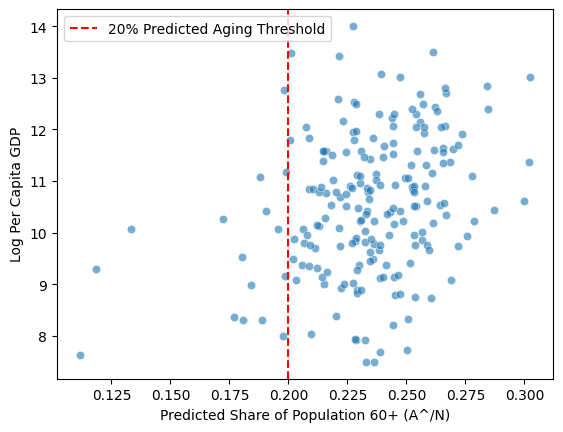

In [ ]:
sns.scatterplot(data=merged_df, x='A_hat_N', y='ln_GDP_N', alpha=0.6)
plt.axvline(cutoff, linestyle="--", color="red", label="20% Predicted Aging Threshold")
plt.xlabel("Predicted Share of Population 60+ (A^/N)")
plt.ylabel("Log Per Capita GDP")
plt.legend()
plt.show()

In [ ]:
print("First Stage F-Statistic:", first_stage.fvalue)

First Stage F-Statistic: 10.76205344020234
